# Beginners

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import sobel, gaussian_filter, uniform_filter, maximum_filter

In [2]:
def non_max_suppression(score_map, radius):
    """Radius-based non-maximum suppression"""
    max_map = maximum_filter(score_map, size=2*radius+1)
    return (score_map == max_map) & (score_map > 0)


def subpixel_refinement(R, y, x):
    """
    Sub-pixel refinement using 2D quadratic fit (parabola)
    """
    if y <= 0 or x <= 0 or y >= R.shape[0]-1 or x >= R.shape[1]-1:
        return y, x

    dx = (R[y, x+1] - R[y, x-1]) / 2
    dy = (R[y+1, x] - R[y-1, x]) / 2
    dxx = R[y, x+1] - 2*R[y, x] + R[y, x-1]
    dyy = R[y+1, x] - 2*R[y, x] + R[y-1, x]

    if dxx != 0:
        x = x - dx / dxx
    if dyy != 0:
        y = y - dy / dyy

    return y, x

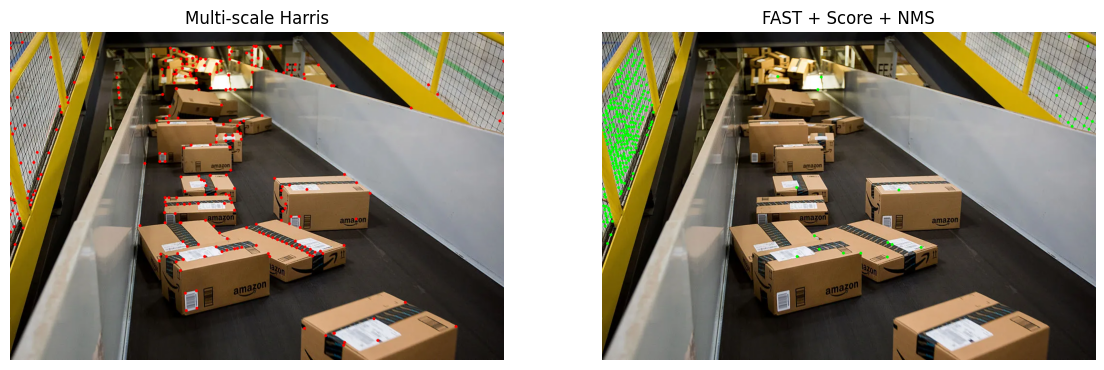

In [3]:
# =============================================================================
#                       MULTI-SCALE HARRIS CORNER
# =============================================================================

def harris_multiscale(
    gray,
    sigmas=(1.0, 2.0, 4.0),
    k=0.04,
    window_size=5,
    nms_radius=4,
    percentile=99,
    top_n=300
):
    corners = []

    for sigma in sigmas:
        # Gradients
        Ix = gaussian_filter(sobel(gray, axis=1), sigma)
        Iy = gaussian_filter(sobel(gray, axis=0), sigma)

        # Structure tensor components
        Ixx = Ix * Ix
        Iyy = Iy * Iy
        Ixy = Ix * Iy

        # Fast summation using convolution
        Sxx = uniform_filter(Ixx, window_size)
        Syy = uniform_filter(Iyy, window_size)
        Sxy = uniform_filter(Ixy, window_size)

        # Harris response
        det = Sxx * Syy - Sxy ** 2
        trace = Sxx + Syy
        R = det - k * trace ** 2

        # Adaptive threshold
        thresh = np.percentile(R, percentile)
        R[R < thresh] = 0

        # NMS
        nms_mask = non_max_suppression(R, nms_radius)

        ys, xs = np.where(nms_mask)

        for y, x in zip(ys, xs):
            ry, rx = subpixel_refinement(R, y, x)
            corners.append((ry, rx, R[y, x], sigma))

    # Sort and keep strongest
    corners.sort(key=lambda x: x[2], reverse=True)
    return corners[:top_n]


# =============================================================================
#                           FAST WITH SCORE + NMS
# =============================================================================

def fast_with_score(gray, threshold=25, n=12, nms_radius=3, top_n=300):
    h, w = gray.shape
    scores = np.zeros_like(gray, dtype=np.float32)

    circle = [
        (0,3),(1,3),(2,2),(3,1),(3,0),(3,-1),(2,-2),(1,-3),
        (0,-3),(-1,-3),(-2,-2),(-3,-1),(-3,0),(-3,1),(-2,2),(-1,3)
    ]

    for y in range(3, h-3):
        for x in range(3, w-3):
            center = int(gray[y, x])
            diffs = []

            for dx, dy in circle:
                diffs.append(abs(int(gray[y+dy, x+dx]) - center))

            diffs = np.array(diffs)

            bright = diffs > threshold
            dark = diffs < -threshold

            if np.sum(bright) >= n or np.sum(dark) >= n:
                scores[y, x] = np.sum(diffs)

    # NMS on scores
    nms_mask = non_max_suppression(scores, nms_radius)
    ys, xs = np.where(nms_mask)

    pts = [(y, x, scores[y, x]) for y, x in zip(ys, xs)]
    pts.sort(key=lambda x: x[2], reverse=True)

    return pts[:top_n]


# =============================================================================
#                               DEMO
# =============================================================================

def main():
    img = cv2.imread("amazon2.jpg")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)

    harris_pts = harris_multiscale(gray)
    fast_pts = fast_with_score(gray.astype(np.uint8))

    harris_img = img.copy()
    for y, x, _, _ in harris_pts:
        cv2.circle(harris_img, (int(x), int(y)), 3, (0,0,255), -1)

    fast_img = img.copy()
    for y, x, _ in fast_pts:
        cv2.circle(fast_img, (x, y), 3, (0,255,0), -1)

    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(harris_img, cv2.COLOR_BGR2RGB))
    plt.title("Multi-scale Harris")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(fast_img, cv2.COLOR_BGR2RGB))
    plt.title("FAST + Score + NMS")
    plt.axis("off")
    plt.show()


if __name__ == "__main__":
    main()


# Intermediate

/tmp/ipython-input-1052249207.py:78: RuntimeWarning: invalid value encountered in sqrt
  lambda_min = (trace - np.sqrt(trace**2 - 4 * det)) / 2


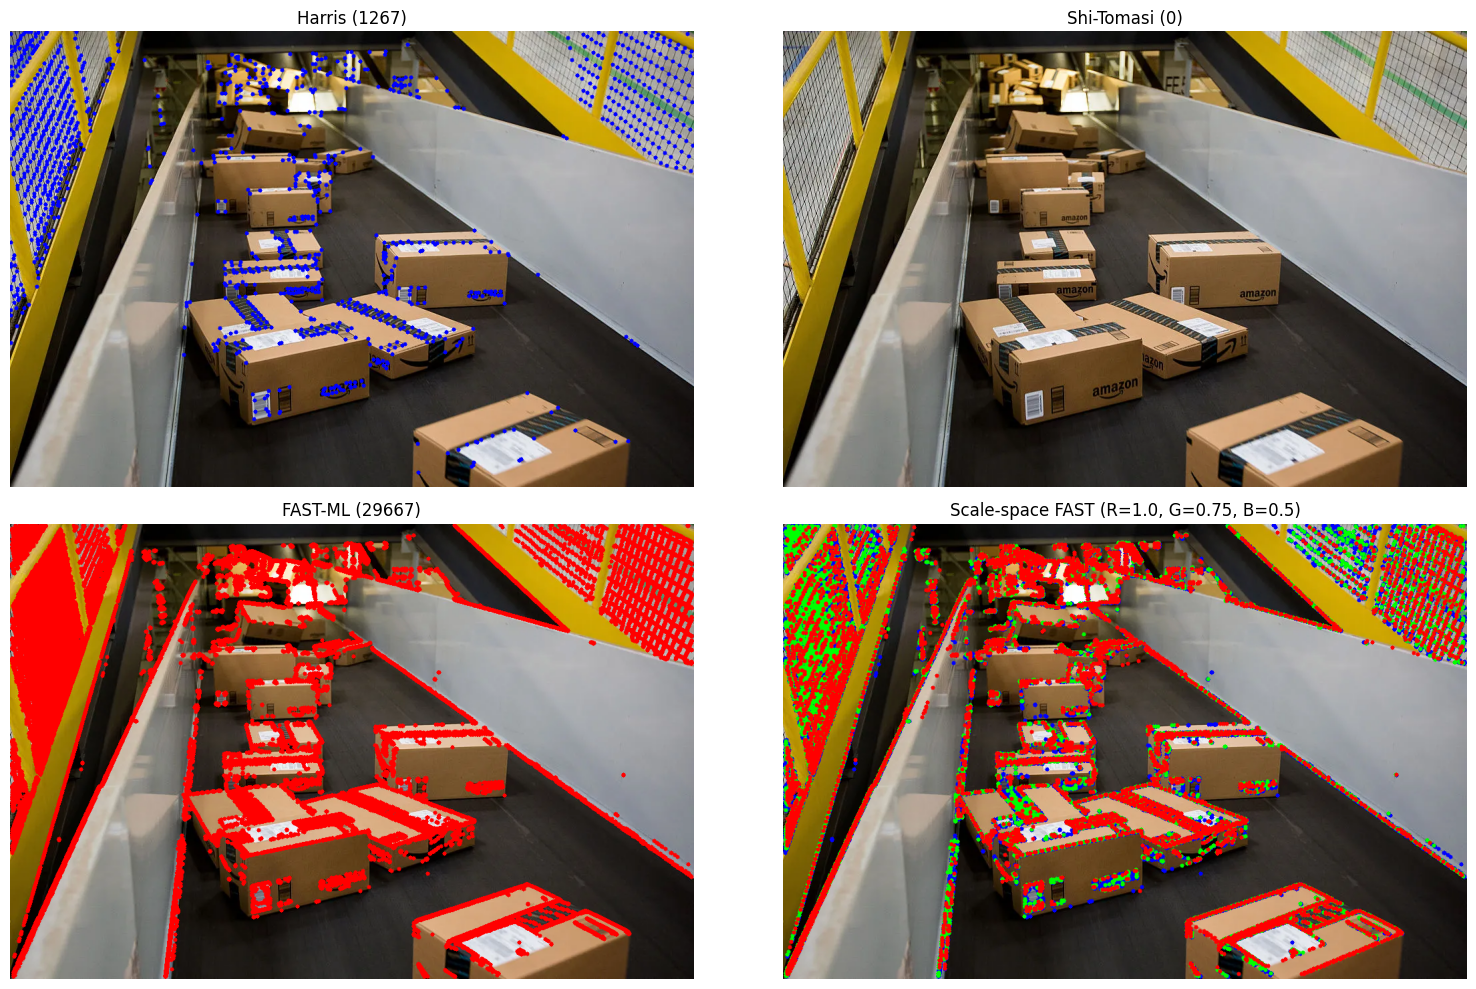

Rotation Repeatability (FAST-ML):
{5: 0.8217548117436883, 15: 0.7293288839451242, 30: 0.7696093302322445, 45: 0.8221593015808811}


In [4]:
"""
FEATURE DETECTORS – COMPLETE IMPLEMENTATION WITH VISUALIZATION

Includes:
1. Harris Corner Detector (from scratch)
2. Shi-Tomasi / KLT Corner Detector
3. FAST Corner Detector (basic)
4. FAST with ML-style acceleration
5. Scale-space FAST
6. Rotation repeatability experiment
7. Matplotlib visualization

Author: Educational CV Implementation
"""

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import sobel, gaussian_filter


# =============================================================================
#                   STRUCTURE TENSOR (COMMON)
# =============================================================================

def compute_structure_tensor(gray, block_size=3):
    Ix = sobel(gray, axis=1)
    Iy = sobel(gray, axis=0)

    Ixx = gaussian_filter(Ix * Ix, sigma=1)
    Iyy = gaussian_filter(Iy * Iy, sigma=1)
    Ixy = gaussian_filter(Ix * Iy, sigma=1)

    Sxx = np.zeros_like(gray)
    Syy = np.zeros_like(gray)
    Sxy = np.zeros_like(gray)

    h = block_size // 2
    for y in range(h, gray.shape[0] - h):
        for x in range(h, gray.shape[1] - h):
            Sxx[y, x] = np.sum(Ixx[y-h:y+h+1, x-h:x+h+1])
            Syy[y, x] = np.sum(Iyy[y-h:y+h+1, x-h:x+h+1])
            Sxy[y, x] = np.sum(Ixy[y-h:y+h+1, x-h:x+h+1])

    return Sxx, Syy, Sxy


# =============================================================================
#                          HARRIS
# =============================================================================

def harris_detector(gray, k=0.04, threshold_ratio=0.01):
    Sxx, Syy, Sxy = compute_structure_tensor(gray)
    det = Sxx * Syy - Sxy ** 2
    trace = Sxx + Syy
    R = det - k * (trace ** 2)

    corners = []
    T = threshold_ratio * np.max(R)

    for y in range(1, gray.shape[0] - 1):
        for x in range(1, gray.shape[1] - 1):
            if R[y, x] > T and R[y, x] == np.max(R[y-1:y+2, x-1:x+2]):
                corners.append((y, x))

    return corners


# =============================================================================
#                        SHI–TOMASI (KLT)
# =============================================================================

def shi_tomasi_detector(gray, threshold_ratio=0.01):
    Sxx, Syy, Sxy = compute_structure_tensor(gray)
    trace = Sxx + Syy
    det = Sxx * Syy - Sxy ** 2

    lambda_min = (trace - np.sqrt(trace**2 - 4 * det)) / 2

    corners = []
    T = threshold_ratio * np.max(lambda_min)

    for y in range(1, gray.shape[0] - 1):
        for x in range(1, gray.shape[1] - 1):
            if lambda_min[y, x] > T:
                corners.append((y, x))

    return corners


# =============================================================================
#                              FAST
# =============================================================================

FAST_CIRCLE = [
    (0, 3), (1, 3), (2, 2), (3, 1), (3, 0), (3, -1), (2, -2), (1, -3),
    (0, -3), (-1, -3), (-2, -2), (-3, -1), (-3, 0), (-3, 1), (-2, 2), (-1, 3)
]


def fast_basic(gray, threshold=25, n=12):
    gray = gray.astype(np.uint8)
    h, w = gray.shape
    corners = []

    for y in range(3, h - 3):
        for x in range(3, w - 3):
            c = int(gray[y, x])
            consec = 0
            max_consec = 0

            for dx, dy in FAST_CIRCLE:
                p = int(gray[y + dy, x + dx])
                if abs(p - c) > threshold:
                    consec += 1
                    max_consec = max(max_consec, consec)
                else:
                    consec = 0

            if max_consec >= n:
                corners.append((y, x))

    return corners


# =============================================================================
#                    FAST – ML STYLE ACCELERATION
# =============================================================================

def fast_ml(gray, threshold=25, n=12):
    gray = gray.astype(np.uint8)
    h, w = gray.shape
    corners = []

    quick_test = [(0, 3), (3, 0), (0, -3), (-3, 0)]

    for y in range(3, h - 3):
        for x in range(3, w - 3):
            c = int(gray[y, x])

            strong = 0
            for dx, dy in quick_test:
                if abs(int(gray[y + dy, x + dx]) - c) > threshold:
                    strong += 1

            if strong < 3:
                continue

            count = 0
            for dx, dy in FAST_CIRCLE:
                if abs(int(gray[y + dy, x + dx]) - c) > threshold:
                    count += 1

            if count >= n:
                corners.append((y, x))

    return corners


# =============================================================================
#                          SCALE-SPACE FAST
# =============================================================================

def fast_scale_space(gray, scales=[1.0, 0.75, 0.5]):
    all_pts = []
    for s in scales:
        resized = cv2.resize(gray, None, fx=s, fy=s)
        pts = fast_ml(resized)
        for y, x in pts:
            all_pts.append((int(y / s), int(x / s), s))
    return all_pts


# =============================================================================
#                        ROTATION REPEATABILITY
# =============================================================================

def rotation_repeatability(gray, detector):
    base = detector(gray)
    base_set = set(base)

    h, w = gray.shape
    center = (w // 2, h // 2)

    results = {}

    for angle in [5, 15, 30, 45]:
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rot = cv2.warpAffine(gray, M, (w, h))

        pts = detector(rot)
        Minv = cv2.getRotationMatrix2D(center, -angle, 1.0)

        matched = 0
        for y, x in pts:
            xr, yr = Minv @ np.array([x, y, 1])
            for py, px in base_set:
                if abs(py - yr) < 5 and abs(px - xr) < 5:
                    matched += 1
                    break

        results[angle] = matched / max(len(base), 1)

    return results


# =============================================================================
#                       VISUALIZATION HELPERS
# =============================================================================

def draw_points(image, points, color):
    img = image.copy()
    for y, x in points:
        cv2.circle(img, (x, y), 3, color, -1)
    return img


def draw_scale_points(image, points):
    img = image.copy()
    for y, x, s in points:
        if s == 1.0:
            color = (255, 0, 0)
        elif s == 0.75:
            color = (0, 255, 0)
        else:
            color = (0, 0, 255)
        cv2.circle(img, (x, y), 3, color, -1)
    return img


# =============================================================================
#                                MAIN
# =============================================================================

def main():
    img = cv2.imread("amazon2.jpg")
    if img is None:
        print("Image not found!")
        return

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)

    harris_pts = harris_detector(gray)
    shi_pts = shi_tomasi_detector(gray)
    fast_pts = fast_ml(gray)
    scale_pts = fast_scale_space(gray)

    img_harris = draw_points(img, harris_pts, (255, 0, 0))
    img_shi = draw_points(img, shi_pts, (0, 255, 0))
    img_fast = draw_points(img, fast_pts, (0, 0, 255))
    img_scale = draw_scale_points(img, scale_pts)

    plt.figure(figsize=(16, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(img_harris, cv2.COLOR_BGR2RGB))
    plt.title(f"Harris ({len(harris_pts)})")
    plt.axis("off")

    plt.subplot(2, 2, 2)
    plt.imshow(cv2.cvtColor(img_shi, cv2.COLOR_BGR2RGB))
    plt.title(f"Shi-Tomasi ({len(shi_pts)})")
    plt.axis("off")

    plt.subplot(2, 2, 3)
    plt.imshow(cv2.cvtColor(img_fast, cv2.COLOR_BGR2RGB))
    plt.title(f"FAST-ML ({len(fast_pts)})")
    plt.axis("off")

    plt.subplot(2, 2, 4)
    plt.imshow(cv2.cvtColor(img_scale, cv2.COLOR_BGR2RGB))
    plt.title("Scale-space FAST (R=1.0, G=0.75, B=0.5)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    print("Rotation Repeatability (FAST-ML):")
    print(rotation_repeatability(gray, fast_ml))


if __name__ == "__main__":
    main()
